<center><img src="./images/Header.png" 
    Width=2000">|

## 1. Business Understanding

### 1.1. Business Objective 
This project aims to determine which movies are currently doing the best at the box office. Several sources of data are used (see [here](https://github.com/setare92-ha/project_eda_movie_profit_analysis/tree/main/zippedData)). These sources include data from [Box Office Mojo](https://www.boxofficemojo.com/), [IMDB](https://www.imdb.com/?ref_=nv_home), [Rotton Tomatoes](https://www.rottentomatoes.com/), [The Movie DataBase](https://www.themoviedb.org/?language=en-US)(TMDB) and [TheNumbers](https://www.the-numbers.com/). The study and its findings will serve stakeholders trying to start a new venture in the movie industry, such as creating a movie studio, or streaming platforms trying to determine movies that would be profitable additions to their collection. 

### 1.2. Background Information
Different metrics may be used to determine the success or profitability of a movie. We may come to different conclusions based on the choice of metric (see [this article](https://www.hollywoodreporter.com/movies/movie-news/what-is-profitable-movie-ever-1269879/) for reference). Here, we choose Return On Investment (ROI) as an appropriate metric to use. ROI may be defined as $$ROI=\frac{Revenue-Expense}{Expense}\times 100$$ We focus on this fiscal metric to determine the most profitable movies. Later, we will focus on the different aspects of a movie (genre, movie ratings, director, etc.) that may correlate to the movie's success in general.  

### 1.3. Data Mining Goals
We would aim for cleaning the data and retaining as much relevant information as possible. Since we're taking data from various sources, we may need to unify them for a more comprehensive analysis. Each source of data may use different jargon/metrics. It's essential to understand what these metrics represent before we attempt to unify data across sources. 

### 1.4. Project Plan
We will first skim the data sources available and get an understanding of the attributes. Then we will clean the data and prepare it for analysis. The important attributes to keep for the different stages of analysis will be identified. Next, we will draw insights from the data to answer the business question. To make the findings more accessible to the stakeholders, we will summarize them as business recommendations at the end. As is known, any study is as good as its limitations. Therefore, at the very end, we will list the assumptions and limitations of the study and how we could potentially better the study in the future. 

**Note:** If you would like to see the study findings, please skip to Section 5 or read the Readme file in the main project repo. 

## 2. Data Understanding
In what follows, we take a preliminary look at the data and understand what information we have available.  

In [47]:
%reset
import ast
from bs4 import BeautifulSoup
import imdb
import numpy
import pandas as pd
import requests
import sqlite3
import matplotlib.pyplot as plt

%matplotlib inline

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


### 2.1. Data from the Box Office Mojo

In [48]:
# import data from Box Office Mojo
df_bom = pd.read_csv("./unzipped_data/bom.movie_gross.csv")
print("summary of the data from Box Office Mojo:")
print(df_bom.info())
df_bom.head(10)

summary of the data from Box Office Mojo:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3387 entries, 0 to 3386
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           3387 non-null   object 
 1   studio          3382 non-null   object 
 2   domestic_gross  3359 non-null   float64
 3   foreign_gross   2037 non-null   object 
 4   year            3387 non-null   int64  
dtypes: float64(1), int64(1), object(3)
memory usage: 132.4+ KB
None


,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010
5,The Twilight Saga: Eclipse,Sum.,300500000.0,398000000,2010
6,Iron Man 2,Par.,312400000.0,311500000,2010
7,Tangled,BV,200800000.0,391000000,2010
8,Despicable Me,Uni.,251500000.0,291600000,2010
9,How to Train Your Dragon,P/DW,217600000.0,277300000,2010


In [49]:
# what percentage of data is missing from the domestic gross & foreign gross columns?
print(
    "% missing data from the domestic gross column:",
    (1 - len(df_bom.dropna(subset=["domestic_gross"])) / len(df_bom)) * 100,
)
print(
    "% missing data from the foreign gross column:",
    (1 - len(df_bom.dropna(subset=["foreign_gross"])) / len(df_bom)) * 100,
)
print(
    "% missing data from the foreign & domestic gross columns combined:",
    (1 - len(df_bom.dropna(subset=["domestic_gross", "foreign_gross"])) / len(df_bom))
    * 100,
)

% missing data from the domestic gross column: 0.8266902863891312
% missing data from the foreign gross column: 39.85828166519043
% missing data from the foreign & domestic gross columns combined: 40.68497195157958


In [50]:
df_bom["foreign_gross"] = (
    df_bom["foreign_gross"].str.replace(",", "", regex=False).astype(float)
)  # convert the foreign gross data type to float
df_bom.dropna(subset=["domestic_gross", "foreign_gross"])[
    ["domestic_gross", "foreign_gross"]
].describe()

,domestic_gross,foreign_gross
count,2.009000e+03,2.009000e+03
mean,4.697311e+07,7.571822e+07
std,8.159966e+07,1.381296e+08
min,4.000000e+02,6.000000e+02
25%,6.650000e+05,3.900000e+06
50%,1.650000e+07,1.930000e+07
75%,5.600000e+07,7.590000e+07
max,9.367000e+08,9.605000e+08


**Observations:**
1. The data from Box Office Mojo has 3387 entries and it contains information on the movie name, studio, and the year it was produced. There's also information on the **domestic gross** and **foregin gross** revenue of the movies. The former is the total revenue a movie earns in its home country (in this case, United States and Canada) while the latter refers to the total revenue a movie earns outside of its home country. This information combined with data on the cost/budget for each movie (missing from the current table) will come in handy for determining the **Return on Investment** metric. One possibility is to use the movie name to read movie_id from the movie_basics table in the IMDB database (loaded in the next section), then scrape the IMDB website to find the budget and add it to this table. We will attempt to do this in the Data Preparation section. 
2. The data type for foreign gross is object (text). We need to change it to float. 
3. We also notice that several entries are missing from the domestic gross (less than 1%) and foreign gross (~40%) columns. This data will need cleaning (including the removal of NaNs) before it can be used in our analysis. 

### 2.2. Data from IMDB

In [51]:
# import data from IMDB
conn = sqlite3.connect("./unzipped_data/im.db")  # open up a connection
cursor = conn.cursor()
# table name query
table_name_query = (
    """SELECT name AS table_name FROM sqlite_master WHERE type='table';"""
)
imdb_sql_table_names = pd.read_sql(table_name_query, conn)
imdb_sql_table_names.head(10)

,table_name
0,movie_basics
1,directors
2,known_for
3,movie_akas
4,movie_ratings
5,persons
6,principals
7,writers


Let's explore each table and understand what useful information they might contain. Below we define a function that queries each table to show all its columns. We will reuse this function to take a peek at the data in all tables.

In [52]:
def show_table_contents(table_name):
    read_table_query = f"""SELECT *
                        FROM {table_name}"""
    print(f"This is the content of {table_name}")
    print(pd.read_sql(read_table_query, conn).head());

#### 1.2.1. IMDB Data: Table Contents

In [53]:
[
    show_table_contents(table_name)
    for table_name in list(imdb_sql_table_names["table_name"])
];

This is the content of movie_basics
    movie_id                    primary_title              original_title  \
0  tt0063540                        Sunghursh                   Sunghursh   
1  tt0066787  One Day Before the Rainy Season             Ashad Ka Ek Din   
2  tt0069049       The Other Side of the Wind  The Other Side of the Wind   
3  tt0069204                  Sabse Bada Sukh             Sabse Bada Sukh   
4  tt0100275         The Wandering Soap Opera       La Telenovela Errante   

   start_year  runtime_minutes                genres  
0        2013            175.0    Action,Crime,Drama  
1        2019            114.0       Biography,Drama  
2        2018            122.0                 Drama  
3        2018              NaN          Comedy,Drama  
4        2017             80.0  Comedy,Drama,Fantasy  
This is the content of directors
    movie_id  person_id
0  tt0285252  nm0899854
1  tt0462036  nm1940585
2  tt0835418  nm0151540
3  tt0835418  nm0151540
4  tt0878654  nm00

**Observations:** }This database has some useful information about **movie ratings** and **number of votes** as well as **directors** and **actors**. Since we would like to focus on a fiscal measure such as ROI, this data does not seem particularly necessary to include in our analysis. However, we may use this data at the end to study correlations between high ratings and other factors mentioned above. 

### 2.3. Data from Rotten Tomatoes

In [54]:
# import data on movie reviews from rotton tomatoes
df_rt_movie_info = pd.read_csv("./unzipped_data/rt.movie_info.tsv", delimiter="\t")
print("Summary of the data on movie info from Rotton Tomatoes:")
print(df_rt_movie_info.info())
df_rt_movie_info.head()

Summary of the data on movie info from Rotton Tomatoes:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1560 entries, 0 to 1559
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            1560 non-null   int64 
 1   synopsis      1498 non-null   object
 2   rating        1557 non-null   object
 3   genre         1552 non-null   object
 4   director      1361 non-null   object
 5   writer        1111 non-null   object
 6   theater_date  1201 non-null   object
 7   dvd_date      1201 non-null   object
 8   currency      340 non-null    object
 9   box_office    340 non-null    object
 10  runtime       1530 non-null   object
 11  studio        494 non-null    object
dtypes: int64(1), object(11)
memory usage: 146.4+ KB
None


,id,synopsis,rating,genre,director,writer,theater_date,dvd_date,currency,box_office,runtime,studio
0,1,"This gritty, fast-paced, and innovative police...",R,Action and Adventure|Classics|Drama,William Friedkin,Ernest Tidyman,"Oct 9, 1971","Sep 25, 2001",NaN,NaN,104 minutes,NaN
1,3,"New York City, not-too-distant-future: Eric Pa...",R,Drama|Science Fiction and Fantasy,David Cronenberg,David Cronenberg|Don DeLillo,"Aug 17, 2012","Jan 1, 2013",$,"600,000",108 minutes,Entertainment One
2,5,Illeana Douglas delivers a superb performance ...,R,Drama|Musical and Performing Arts,Allison Anders,Allison Anders,"Sep 13, 1996","Apr 18, 2000",NaN,NaN,116 minutes,NaN
3,6,Michael Douglas runs afoul of a treacherous su...,R,Drama|Mystery and Suspense,Barry Levinson,Paul Attanasio|Michael Crichton,"Dec 9, 1994","Aug 27, 1997",NaN,NaN,128 minutes,NaN
4,7,NaN,NR,Drama|Romance,Rodney Bennett,Giles Cooper,NaN,NaN,NaN,NaN,200 minutes,NaN


The data from Rotten Tomatoes contains information on the **total revenue generated by a movie** (box_office). It also contains other interesting information such as **genre** and **rating**. What is striking though is that the box_office field has a high percentage of missing data (roughly 78%). It's not clear how useful this data will be in terms of considering the revenue. The other problem is that the name of the movies is not listed so there is no way to cross-reference this table with other tables. 

In [55]:
df_rt_reviews = pd.read_csv("./unzipped_data/rt.reviews.tsv", sep="\t", encoding="mbcs")
print(df_rt_reviews.info())
df_rt_reviews.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54432 entries, 0 to 54431
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          54432 non-null  int64 
 1   review      48869 non-null  object
 2   rating      40915 non-null  object
 3   fresh       54432 non-null  object
 4   critic      51710 non-null  object
 5   top_critic  54432 non-null  int64 
 6   publisher   54123 non-null  object
 7   date        54432 non-null  object
dtypes: int64(2), object(6)
memory usage: 3.3+ MB
None


,id,review,rating,fresh,critic,top_critic,publisher,date
0,3,A distinctly gallows take on contemporary fina...,3/5,fresh,PJ Nabarro,0,Patrick Nabarro,"November 10, 2018"
1,3,It's an allegory in search of a meaning that n...,NaN,rotten,Annalee Newitz,0,io9.com,"May 23, 2018"
2,3,... life lived in a bubble in financial dealin...,NaN,fresh,Sean Axmaker,0,Stream on Demand,"January 4, 2018"
3,3,Continuing along a line introduced in last yea...,NaN,fresh,Daniel Kasman,0,MUBI,"November 16, 2017"
4,3,... a perverse twist on neorealism...,NaN,fresh,NaN,0,Cinema Scope,"October 12, 2017"


This table lists the full reviews people left for movies. The data regarding movie ratings can be combined with that from IMDB if we do an analysis that looks at whether higher ratings correlate with better fiscal outcomes. Further down the line, it may also be possible to train a model that can classify the reviews as positive or negative. Then use that to do further studies on how different movies were generally received. We abandon this idea for now. 

### 2.4. Data from TheMovieDB

In [56]:
# import data from the movie db
df_movie_tmdb = pd.read_csv("./unzipped_data/tmdb.movies.csv", index_col=0)
print(df_movie_tmdb.info())
df_movie_tmdb.head()

<class 'pandas.core.frame.DataFrame'>
Index: 26517 entries, 0 to 26516
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   genre_ids          26517 non-null  object 
 1   id                 26517 non-null  int64  
 2   original_language  26517 non-null  object 
 3   original_title     26517 non-null  object 
 4   popularity         26517 non-null  float64
 5   release_date       26517 non-null  object 
 6   title              26517 non-null  object 
 7   vote_average       26517 non-null  float64
 8   vote_count         26517 non-null  int64  
dtypes: float64(2), int64(2), object(5)
memory usage: 2.0+ MB
None


,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


This table has information on movie ratings (**vote_average**) and **popularity**. The popularity column does not have a specific range and is determined based on several factors including the recentness of the release and the number of votes. This table also includes information on the **genres**. However, they're listed as ids. If we intend to use this information, we will need to first map the ids to the actual genres using a mapping that TMDB provides itself. I created a separate table that does this using the information [here](https://www.themoviedb.org/talk/5daf6eb0ae36680011d7e6ee). 

In [57]:
df_genre_tmdb = pd.read_csv("./unzipped_data/tmdb.genres.csv")
df_genre_tmdb.head()

,genre,id
0,Action,28
1,Adventure,12
2,Animation,16
3,Comedy,35
4,Crime,80


Once we integrate the genres with this table, we can join this table with the tables from IMDB and Rotton Tomatoes containing similar information. We shelf these ideas for the last stage of the analysis.

### 2.5. Data from TheNumbers

In [58]:
# import data from The Numbers
df_thenumbers = pd.read_csv("./unzipped_data/tn.movie_budgets.csv",index_col=0)
print("Summary of the data on movie info from The Numbers:")
print(df_thenumbers.info())
df_thenumbers.head()

Summary of the data on movie info from The Numbers:
<class 'pandas.core.frame.DataFrame'>
Index: 5782 entries, 1 to 82
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   release_date       5782 non-null   object
 1   movie              5782 non-null   object
 2   production_budget  5782 non-null   object
 3   domestic_gross     5782 non-null   object
 4   worldwide_gross    5782 non-null   object
dtypes: object(5)
memory usage: 271.0+ KB
None


,release_date,movie,production_budget,domestic_gross,worldwide_gross
id,,,,,
1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


This table will be the main source we will use to determine the ROI metric. It has more entries compared to the one from BOX Office Mojo; it has no NaNs so all the data can be used. Furthermore, it has data on the production budget, which is missing from the data extracted from the Box Office Mojo. One might consider scraping the web to find production budgets for the movies listed in the Box Office Mojo database but we choose to rely solely on this table for now.  

Note that the production_bbudget, domestic_gross and worldwide_gross columns are of the type object. In order to easily do mathematical operations on them, we need to convert them to float. 

In [59]:
cols_to_convert = ["production_budget", "domestic_gross","worldwide_gross"]

for col in cols_to_convert:
    df_thenumbers[col] = df_thenumbers[col].str.replace(",","").replace("\$","",regex=True).astype(float)

In [60]:
df_thenumbers[cols_to_convert].describe() # take a look at some statistics for the data

,production_budget,domestic_gross,worldwide_gross
count,5.782000e+03,5.782000e+03,5.782000e+03
mean,3.158776e+07,4.187333e+07,9.148746e+07
std,4.181208e+07,6.824060e+07,1.747200e+08
min,1.100000e+03,0.000000e+00,0.000000e+00
25%,5.000000e+06,1.429534e+06,4.125415e+06
50%,1.700000e+07,1.722594e+07,2.798445e+07
75%,4.000000e+07,5.234866e+07,9.764584e+07
max,4.250000e+08,9.366622e+08,2.776345e+09


## 3. Data Preparation

### 3.1. Box Office Mojo

**Can we find movie budgets using web scraping?**

In this section, we will use web scraping to find the budget for movies listed in the Box Office Mojo dataset. We will first use the movie name to join the BOM dataset with the movie_basics table from the IMDB dataset. Then using the movie_id from the IMDB dataset, we can scrape the corresponding webpages to find the estimated budgets for each movie. 

In [61]:
q = """SELECT movie_id, primary_title, genres FROM movie_basics""" # query to read the movie_basics table
df_imdb_moviebasics = pd.read_sql(q, conn) # store the table in a pandas dataframe
df_imdb_moviebasics.rename(columns = {"primary_title":"title"},inplace=True); # change primary_title column name to match the BOM dataset
df_bom_imdb_merged = pd.merge(df_bom, df_imdb_moviebasics,how="inner", on="title") # merge the two tables
print("percentage of missing data:",(len(df_bom)-len(df_bom_imdb_merged))/len(df_bom)*100)
df_bom_imdb_merged.head(10)

percentage of missing data: 0.6200177147918512


,title,studio,domestic_gross,foreign_gross,year,movie_id,genres
0,Toy Story 3,BV,415000000.0,652000000.0,2010,tt0435761,"Adventure,Animation,Comedy"
1,Inception,WB,292600000.0,535700000.0,2010,tt1375666,"Action,Adventure,Sci-Fi"
2,Shrek Forever After,P/DW,238700000.0,513900000.0,2010,tt0892791,"Adventure,Animation,Comedy"
3,The Twilight Saga: Eclipse,Sum.,300500000.0,398000000.0,2010,tt1325004,"Adventure,Drama,Fantasy"
4,Iron Man 2,Par.,312400000.0,311500000.0,2010,tt1228705,"Action,Adventure,Sci-Fi"
5,Tangled,BV,200800000.0,391000000.0,2010,tt0398286,"Adventure,Animation,Comedy"
6,Despicable Me,Uni.,251500000.0,291600000.0,2010,tt1323594,"Animation,Comedy,Family"
7,How to Train Your Dragon,P/DW,217600000.0,277300000.0,2010,tt0892769,"Action,Adventure,Animation"
8,The Chronicles of Narnia: The Voyage of the Da...,Fox,104400000.0,311300000.0,2010,tt0980970,"Adventure,Family,Fantasy"
9,The King's Speech,Wein.,135500000.0,275400000.0,2010,tt1504320,"Biography,Drama,History"


Let's remove portions of the data that have missing information on the foreign and domestic revenue. As mentioned in Section 2.1, this is about 40% of the data. 

In [62]:
df_bom_imdb_merged.dropna(subset=["domestic_gross", "foreign_gross"], inplace=True) 

**Note:** IMDB prevents scraping of its webpages in this manner. We may need to scrape other sources such as OMDB to get this data. This may be a lot of additional effort. Let's first see how much additional data does this really provide us with?  

**Question:** How much additional data on movies does the Box Office Mojo dataset contain compared to the dataset from The Numbers? 

In [63]:
df_thenumbers.rename(columns={"movie":"title"},inplace=True)
df_thenumbers["title"] = df_thenumbers["title"].str.title()
print("percentage of additional data contained in the Box Office Mojo Dataset compared to the dataset from The Numbers:")
(len(df_bom_imdb_merged.index)-len(pd.merge(df_thenumbers,df_bom_imdb_merged,how="inner",on="title").index))/len(df_thenumbers.index)*100

percentage of additional data contained in the Box Office Mojo Dataset compared to the dataset from The Numbers:


15.150466966447595

The additional data is about 10%. At this stage, we make a judgement call to ignore the dataset from Box Office Mojo and solely rely on the dataset from The Numbers. 

## IMDB

In [64]:
q2 = """SELECT mvb.movie_id AS imdb_movie_id, mvb.start_year AS release_year, mvb.primary_title AS title, mvb.genres, mvr.averagerating AS imdb_average_rating
            FROM movie_basics mvb
                JOIN movie_ratings as mvr
                USING(movie_id)
"""
df_imdb_mvr = pd.read_sql(q2,conn)
df_imdb_mvr.head()
df_imdb_mvr["title"] = df_imdb_mvr["title"].str.title()
print(df_imdb_mvr.isna().sum())
df_imdb_mvr.head()

imdb_movie_id            0
release_year             0
title                    0
genres                 804
imdb_average_rating      0
dtype: int64


,imdb_movie_id,release_year,title,genres,imdb_average_rating
0,tt0063540,2013,Sunghursh,"Action,Crime,Drama",7.0
1,tt0066787,2019,One Day Before The Rainy Season,"Biography,Drama",7.2
2,tt0069049,2018,The Other Side Of The Wind,Drama,6.9
3,tt0069204,2018,Sabse Bada Sukh,"Comedy,Drama",6.1
4,tt0100275,2017,The Wandering Soap Opera,"Comedy,Drama,Fantasy",6.5


In [65]:
df_imdb_duplicate_title_year = pd.concat(g for _, g in df_imdb_mvr.groupby(["title","release_year"]) if len(g) > 1)

In [66]:
df_imdb_mvr = df_imdb_mvr[~ df_imdb_mvr.duplicated(subset=['title','release_year'])]

### 3.1. The Movie DataBase

**Replace genre ids with categories**

In [67]:
df_genre_tmdb["id"].to_list()
df_genre_tmdb["genre"].str.strip().to_list()
# make a dictionary where keys are genre ids and values are the actual genres
genre_tmdb_dict = {key:value for key,value in zip(df_genre_tmdb["id"].to_list(),df_genre_tmdb["genre"].str.strip().to_list())}

In [68]:
def replace_id_with_genre(key_list: list, genre_dict: dict) -> str:
    """Given a list of keys from a dictionary, this function replaces the keys with associated values.
    
    Args:
        key_list: list containing certain keys in a dictionary
        genre_dict: the dictionary itself
    
    Returns:
        A string containing corresponding values in genre_dict
    """
    value_list = [genre_dict.get(id,id) for id in ast.literal_eval(key_list)] 
    return ",".join(value_list)

# apply the function to the series
df_movie_tmdb["genre_ids"] = df_movie_tmdb["genre_ids"].apply(func = replace_id_with_genre, genre_dict = genre_tmdb_dict)
df_movie_tmdb.rename(columns={"genre_ids":"genres_category","vote_average":"tmdb_average_rating"},inplace=True)

In [69]:
df_movie_tmdb.head(3) # take a peek at the data

,genres_category,id,original_language,original_title,popularity,release_date,title,tmdb_average_rating,vote_count
0,"Adventure,Fantasy,Family",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"Fantasy,Adventure,Animation,Family",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,"Adventure,Action,Science Fiction",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368


**Make necessary changes to data types**

In [70]:
# change the data type for release_date to datetime
df_movie_tmdb["release_date"] = pd.to_datetime(df_movie_tmdb["release_date"])
# create a column release_year that contains only the year. This will come in handy later on when doing merges
df_movie_tmdb["release_year"] = df_movie_tmdb["release_date"].dt.year

**Address entries with duplicate titles**

In [71]:
#df_movie_tmdb[df_movie_tmdb.duplicated(subset = ["title","release_year"])]
len(pd.concat(g for _, g in df_movie_tmdb.groupby(["title","id"]) if len(g) > 1))
df_movie_tmdb.drop_duplicates(subset=['title','id'], keep='first', inplace=True)

### 3.3. The Numbers

**Calculate the domestic and worldwide ROI**

Let's add another column to this table that contains the ROI. We can consider an ROI that only considers the domestic revenue and another one that considers both domestic and foregin revenues. 

In [72]:
df_thenumbers["ROI_domestic"] = (df_thenumbers["domestic_gross"] - df_thenumbers["production_budget"])/df_thenumbers["production_budget"]*100
df_thenumbers["ROI_worldwide"] = (df_thenumbers["worldwide_gross"] - df_thenumbers["production_budget"])/df_thenumbers["production_budget"]*100

In [73]:
# change the data type for release_date to datetime
df_thenumbers["release_date"] = pd.to_datetime(df_thenumbers["release_date"])
# create a column release_year that contains only the year. This will come in handy later on when doing merges
df_thenumbers["release_year"] = df_thenumbers["release_date"].dt.year

Let's sort the dataframe based on ROI from highest to lowest to identify the most profitable movies. 

In [74]:
df_thenumbers.sort_values(by="ROI_worldwide", ascending=False).head(5)

,release_date,title,production_budget,domestic_gross,worldwide_gross,ROI_domestic,ROI_worldwide,release_year
id,,,,,,,,
46,1972-06-30,Deep Throat,25000.0,45000000.0,45000000.0,179900.000000,179900.000000,1972
14,1980-03-21,Mad Max,200000.0,8750000.0,99750000.0,4275.000000,49775.000000,1980
93,2009-09-25,Paranormal Activity,450000.0,107918810.0,194183034.0,23881.957778,43051.785333,2009
80,2015-07-10,The Gallows,100000.0,22764410.0,41656474.0,22664.410000,41556.474000,2015
7,1999-07-14,The Blair Witch Project,600000.0,140539099.0,248300000.0,23323.183167,41283.333333,1999


**Add Genre and movie rating information to the dataset**

**Addressing duplicate entries**

**Question:** Are there any movies with duplicate title and year in the dataset? 

In [75]:
df_thenumbers[df_thenumbers.duplicated(subset = ["title","release_year"])]
pd.concat(g for _, g in df_thenumbers.groupby(["title","release_year"]) if len(g) > 1)

,release_date,title,production_budget,domestic_gross,worldwide_gross,ROI_domestic,ROI_worldwide,release_year
id,,,,,,,,
56,2009-06-05,Home,12000000.0,0.0,0.0,-100.0000,-100.0000,2009
60,2009-04-23,Home,500000.0,15433.0,44793168.0,-96.9134,8858.6336,2009


The data in row 56 seems suspicious. We will choose to drop this row. 

In [76]:
df_thenumbers.drop(index=56,inplace=True)

**Question:** Are there any movies with duplicate tilte? 

In [77]:
print("There are ", df_thenumbers.duplicated(subset="title").sum(), "entries with duplicate titles.")
pd.concat(g for _, g in df_thenumbers.groupby(["title"]) if len(g) > 1).head(6)

There are  82 entries with duplicate titles.


,release_date,title,production_budget,domestic_gross,worldwide_gross,ROI_domestic,ROI_worldwide,release_year
id,,,,,,,,
71,1954-12-23,"20,000 Leagues Under The Sea",5000000.0,28200000.0,28200000.0,464.000000,464.000000,1954
15,1916-12-24,"20,000 Leagues Under The Sea",200000.0,8000000.0,8000000.0,3900.000000,3900.000000,1916
49,2010-04-30,A Nightmare On Elm Street,35000000.0,63075011.0,117729621.0,80.214317,236.370346,2010
17,1984-11-09,A Nightmare On Elm Street,1800000.0,25504513.0,25504513.0,1316.917389,1316.917389,1984
81,2019-05-24,Aladdin,182000000.0,246734314.0,619234314.0,35.568304,240.238634,2019
33,1992-11-11,Aladdin,28000000.0,217350219.0,504050219.0,676.250782,1700.179354,1992


There are clearly movies with duplicate titles but different release years. If we merge this dataset with the ones fro IMDB/TMDB using both title and release year, we will get a lot of NaNs because slight differences in the title string or release year will prevent a match. I prefer to join only based on title but the duplicate titles in both this dataset and the one from IMDB will cause issues because upon merge, they will get duplicated many times, creating entries with fake data. We don't want that. Since movies with duplicate titles are only a small portion of the whole database, we will store them in a separate dataframe for now and will drop them from the main dataset. We can work on integrating these entries in a neater way later on. 

In [78]:
df_tn_duplicate_titles = pd.concat(g for _, g in df_thenumbers.groupby(["title"]) if len(g) > 1)
df_thenumbers_noduplicates = df_thenumbers[~ df_thenumbers.duplicated(subset="title")]

In [79]:
# merge the dataset from The Numbers with the dataset from IMDB to record the genres as well as ratings
df_tn_imdb_merged = pd.merge(df_thenumbers_noduplicates, df_imdb_mvr, on=['title','release_year'], how="left")

df_merged_all = pd.merge(df_tn_imdb_merged, df_movie_tmdb[["title","genres_category","tmdb_average_rating"]], on="title", how="left")

df_merged_all["genres"]=df_merged_all["genres"].fillna(df_merged_all["genres_category"])

df_merged_all.drop(columns = "genres_category", inplace=True)
print(df_merged_all.isna().sum())

df_merged_all[(df_merged_all['genres'].isna()) & (df_merged_all['release_year']>=2010)]['release_year'].value_counts().sort_values(ascending=False)

release_date              0
title                     0
production_budget         0
domestic_gross            0
worldwide_gross           0
ROI_domestic              0
ROI_worldwide             0
release_year              0
imdb_movie_id          4237
genres                 3718
imdb_average_rating    4237
tmdb_average_rating    4117
dtype: int64


release_year
2015    85
2010    80
2011    47
2016    43
2012    39
2014    38
2013    36
2017    31
2019    21
2018    14
2020     3
Name: count, dtype: int64

In [80]:
df_merged_all.sort_values(by="ROI_worldwide", ascending=False).head()

,release_date,title,production_budget,domestic_gross,worldwide_gross,ROI_domestic,ROI_worldwide,release_year,imdb_movie_id,genres,imdb_average_rating,tmdb_average_rating
5790,1972-06-30,Deep Throat,25000.0,45000000.0,45000000.0,179900.000000,179900.000000,1972,NaN,NaN,NaN,NaN
5666,1980-03-21,Mad Max,200000.0,8750000.0,99750000.0,4275.000000,49775.000000,1980,NaN,NaN,NaN,NaN
5541,2009-09-25,Paranormal Activity,450000.0,107918810.0,194183034.0,23881.957778,43051.785333,2009,NaN,NaN,NaN,NaN
5724,2015-07-10,The Gallows,100000.0,22764410.0,41656474.0,22664.410000,41556.474000,2015,tt2309260,"Horror,Mystery,Thriller",4.2,4.8
5456,1999-07-14,The Blair Witch Project,600000.0,140539099.0,248300000.0,23323.183167,41283.333333,1999,NaN,NaN,NaN,NaN


A peek at the IMDB database shows that it only contains movies from 2010 onwards. Therefore, to fill out the NaNs for the genre and rating in the merged database, we can sweep this dataset again for movies that were released 2010 onwards whose genre is unidentified. We can then swift through the IMDB dataset to find movies whose titles are not a perfect match (thus not identified by the merge command) but a very close match. Among movies whose titles are a close match, we will select the ones with release dates that are very similar (threshold: 2 years apart) to the original movie under consideration. This lets us fill some of the NaN entries for genre and rating. 

In [81]:
df_nan_2010_onwards = df_merged_all[(df_merged_all['genres'].isna()) & (df_merged_all['release_year']>=2010)]
idx=[]
idx_df_nan=[]

# only reset index once (to avoid errors when cell is run multiple times)
if 'reset_bool' not in globals():
    df_imdb_mvr.reset_index(inplace=True)
    reset_bool = True

for i in range(0,len(df_nan_2010_onwards.index)):
        if (df_nan_2010_onwards["title"].iloc[i] in df_imdb_mvr["title"].to_list()):
            idx_df_nan.append(i)
            idx.append(df_imdb_mvr["title"].index[df_imdb_mvr["title"].str.contains(df_nan_2010_onwards["title"].iloc[i])].to_list())
            
            idx_closest_year = (df_imdb_mvr["release_year"].iloc[idx[-1]]-df_nan_2010_onwards["release_year"].iloc[i]).idxmin()
            if numpy.abs((df_imdb_mvr["release_year"].iloc[idx[-1]]-df_nan_2010_onwards["release_year"].iloc[i]).min())<=2:                
                columns_to_fill = ["imdb_movie_id", "genres", "imdb_average_rating"]
                for col in columns_to_fill:
                    # print(df_nan_2010_onwards[["title","release_year"]].iloc[i])
                    # print(df_imdb_mvr[["title","release_year"]].iloc[idx_closest_year])
                    df_nan_2010_onwards.iloc[i,df_nan_2010_onwards.columns.get_loc(col)] = df_imdb_mvr.iloc[idx_closest_year,df_imdb_mvr.columns.get_loc(col)] 
                                            
print(df_nan_2010_onwards.isna().sum()/len(df_nan_2010_onwards.index))

release_date           0.000000
title                  0.000000
production_budget      0.000000
domestic_gross         0.000000
worldwide_gross        0.000000
ROI_domestic           0.000000
ROI_worldwide          0.000000
release_year           0.000000
imdb_movie_id          0.773455
genres                 0.773455
imdb_average_rating    0.773455
tmdb_average_rating    1.000000
dtype: float64


We recovered ~23% of the missing data. 

In [82]:
# change column names so we can join without conflicts
df_nan_2010_onwards.rename(columns={"genres":"filled_genres", "imdb_movie_id":"filled_imdb_movie_id", "imdb_average_rating":"filled_imdb_average_rating"}, inplace=True)
# merge the dataframe where NaNs are filled with the original dataframe
df_new = pd.merge(df_merged_all, df_nan_2010_onwards[["title","filled_genres", "filled_imdb_movie_id", "filled_imdb_average_rating"]], on="title", how = "left")

na_cols_to_fill = ["imdb_movie_id","genres","imdb_average_rating"]
cols_to_fill_with = ["filled_imdb_movie_id","filled_genres","filled_imdb_average_rating"]

# fill out the NaNs in the original dataframe
for na_col, col_to_fill in zip(na_cols_to_fill, cols_to_fill_with):
    df_new[na_col] = df_new[na_col].fillna(df_new[col_to_fill])

# drop the redundant columns
df_new.drop(columns = cols_to_fill_with, inplace=True)
df_new.isna().sum()

C:\Users\setar\AppData\Local\Temp\ipykernel_16420\3788012409.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_nan_2010_onwards.rename(columns={"genres":"filled_genres", "imdb_movie_id":"filled_imdb_movie_id", "imdb_average_rating":"filled_imdb_average_rating"}, inplace=True)


release_date              0
title                     0
production_budget         0
domestic_gross            0
worldwide_gross           0
ROI_domestic              0
ROI_worldwide             0
release_year              0
imdb_movie_id          4138
genres                 3619
imdb_average_rating    4138
tmdb_average_rating    4117
dtype: int64

I repeated the same process with the remaining entries that have missing genres using the dataset from TMDB but no close matches were found. Since the movie industry has changed over the years and to remain relevant, it may be more useful to look at the trends from recent years, we choose to strip the main dataset containing ROI information (source: The Numbers) such that it only contains movies from 2010 onwards. 

In [83]:
df_new[df_new["release_year"]>=2010].info()

<class 'pandas.core.frame.DataFrame'>
Index: 2289 entries, 1 to 5824
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   release_date         2289 non-null   datetime64[ns]
 1   title                2289 non-null   object        
 2   production_budget    2289 non-null   float64       
 3   domestic_gross       2289 non-null   float64       
 4   worldwide_gross      2289 non-null   float64       
 5   ROI_domestic         2289 non-null   float64       
 6   ROI_worldwide        2289 non-null   float64       
 7   release_year         2289 non-null   int32         
 8   imdb_movie_id        1688 non-null   object        
 9   genres               1951 non-null   object        
 10  imdb_average_rating  1688 non-null   float64       
 11  tmdb_average_rating  1453 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int32(1), object(3)
memory usage: 223.5+ KB


In [84]:
df_merged_2010_onwards = df_new[df_new["release_year"]>=2010].copy()

In [85]:
print(df_merged_2010_onwards.info())
df_merged_2010_onwards.isna().sum()

<class 'pandas.core.frame.DataFrame'>
Index: 2289 entries, 1 to 5824
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   release_date         2289 non-null   datetime64[ns]
 1   title                2289 non-null   object        
 2   production_budget    2289 non-null   float64       
 3   domestic_gross       2289 non-null   float64       
 4   worldwide_gross      2289 non-null   float64       
 5   ROI_domestic         2289 non-null   float64       
 6   ROI_worldwide        2289 non-null   float64       
 7   release_year         2289 non-null   int32         
 8   imdb_movie_id        1688 non-null   object        
 9   genres               1951 non-null   object        
 10  imdb_average_rating  1688 non-null   float64       
 11  tmdb_average_rating  1453 non-null   float64       
dtypes: datetime64[ns](1), float64(7), int32(1), object(3)
memory usage: 223.5+ KB
None


release_date             0
title                    0
production_budget        0
domestic_gross           0
worldwide_gross          0
ROI_domestic             0
ROI_worldwide            0
release_year             0
imdb_movie_id          601
genres                 338
imdb_average_rating    601
tmdb_average_rating    836
dtype: int64

Let's combine the rating from IMDB and TMDB into one column:

In [86]:
# fill NaNs
df_merged_2010_onwards.loc[:,"imdb_average_rating"] = df_merged_2010_onwards["imdb_average_rating"].fillna(df_merged_2010_onwards["tmdb_average_rating"]).copy()
# drop redundant column
df_merged_2010_onwards.drop(columns = "tmdb_average_rating", inplace=True) 
df_merged_2010_onwards.rename(columns = {"imdb_average_rating": "average_rating"}, inplace=True)
df_merged_2010_onwards.isna().sum()

release_date           0
title                  0
production_budget      0
domestic_gross         0
worldwide_gross        0
ROI_domestic           0
ROI_worldwide          0
release_year           0
imdb_movie_id        601
genres               338
average_rating       338
dtype: int64

In [87]:
df_missing_genres = df_merged_2010_onwards[df_merged_2010_onwards["genres"].isna()] # get a slice of the dataframe that has missing genres
df_missing_genres = df_missing_genres.copy() # make a copy of the slice
print(f"There is {len(df_missing_genres.index)} missing data points.") 

There is 338 missing data points.


We still have some missing information on genres and ratings. To recover this missing information, we use a Python library called imdb. This library will give us the ability to get information on a given movie using its title. The operation is time-consuming, which is why we used all other means to recover the missing information and we will use this as the last resort. 

In [88]:
from typing import Tuple
def get_movie_info(mv_title: str) -> Tuple[str, str, float]:
    """ Given the title of a movie, this function returns information on the movie id, its genre and rating.
    Args:
        mv_title: a string containing the movie title
    Returns:
        id: a string containing the IMDB movie id
        genres: a string containing all genres listed for the movie on IMDB
        rating: float variable indicating the average movie rating on IMDB
    """
    ia = imdb.IMDb()
    search_movie = ia.search_movie(mv_title)
    movie = ia.get_movie(search_movie[0].getID())

    if ("genres" in movie.keys()) and ("rating" in movie.keys()):
        id = 'tt'+search_movie[0].getID()
        genres =  ",".join(movie['genres'])
        rating = movie['rating']
    else:
        id = 'NaN'
        genres = 'NaN'
        rating = float('NaN')
    return id, genres, rating

# a,b,c = get_genre_from_imdb("Star Wars")

# wrapper function to be used on the dataframe
def apply_get_genre(row):
    row["imdb_movie_id"],row["genres"], row["average_rating"] = get_movie_info(row["title"])
    return row

In [89]:
%%time
ia = imdb.IMDb()
search_movie = ia.search_movie("Inception")
movie = ia.get_movie(search_movie[0].getID())
if ("genres" in movie.keys()) and ("rating" in movie.keys()):
        id = 'tt'+search_movie[0].getID()
        genres =  ",".join(movie['genres'])
        rating = movie['rating']
id, genres, rating

CPU times: total: 1.75 s
Wall time: 5.51 s


('tt1375666', 'Action,Adventure,Sci-Fi,Thriller', 8.8)

A sample test case took roughly 5 sseconds to run. 338 entries may take about half an hour to run if we assume that the runtime varies linearly with the number of entries. As mentioned, this operation is not fast and could benefit from some optimization. Nevertheless, we proceed by using the function to obtain the final dataframe we will work with. 

In [90]:
%%time
df_filled_genres = df_missing_genres.apply(func = apply_get_genre, axis = 1) # apply the wrapper function to the dataframe with missing data 

CPU times: total: 7min 47s
Wall time: 1h 35min 33s


In [91]:
df_merged_2010_onwards.drop(index = df_filled_genres.index, axis=1, inplace=True) # drop the entries corresponding to the slice (entries with missing genres)
df_final = pd.concat([df_merged_2010_onwards, df_filled_genres]) # concatenate the two dataframes  to recover missing genres
df_final['genres'] = df_final['genres'].astype(str)

In [92]:
print(df_final.isna().sum()) # check that all genres are recovered
df_final.head()

release_date           0
title                  0
production_budget      0
domestic_gross         0
worldwide_gross        0
ROI_domestic           0
ROI_worldwide          0
release_year           0
imdb_movie_id        263
genres                 0
average_rating        15
dtype: int64


,release_date,title,production_budget,domestic_gross,worldwide_gross,ROI_domestic,ROI_worldwide,release_year,imdb_movie_id,genres,average_rating
1,2011-05-20,Pirates Of The Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,-41.289850,154.667286,2011,tt1298650,"Action,Adventure,Fantasy",6.6
2,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,-87.782186,-57.210757,2019,tt6565702,"Action,Adventure,Sci-Fi",6.0
3,2015-05-01,Avengers: Age Of Ultron,330600000.0,459005868.0,1.403014e+09,38.840250,324.384139,2015,tt2395427,"Action,Adventure,Sci-Fi",7.3
6,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,126.271827,582.711400,2018,tt4154756,"Action,Adventure,Sci-Fi",8.5
8,2017-11-17,Justice League,300000000.0,229024295.0,6.559452e+08,-23.658568,118.648403,2017,tt0974015,"Action,Adventure,Fantasy",6.5


Let's drop the remaining entries where average rating is NaN. 

In [93]:
df_final.dropna(subset="average_rating", inplace=True)

We have managed to recover most missing genres after several steps. Due to the previous step being extremely time-consuming, we will write this data to a csv file for later reuse and to avoid running the prior computationally demanding step again. 

In [94]:
df_final.to_csv('./unzipped_data/processed/movie_info.csv')

I manually copied this file to another location for reading it below since I wanted to make sure I have an intact version of the data. 

In [95]:
df_final = pd.read_csv('./unzipped_data/movie_info.csv')

## 4. Data Analysis

There are several entries with 0 for domestic and worldwide gross. Since we cannot be sure of whether these movies actually had any revenue or this is the case of bad data entry, we will drop these entries. 

In [96]:
df_final_zero_gross = df_final[(df_final["domestic_gross"]==0) | (df_final["worldwide_gross"]==0)].copy()
df_final.drop(labels = df_final_zero_gross.index, inplace=True)
print("The final dataset has ", len(df_final.index), " entries.")

The final dataset has  1866  entries.


Let's take a look at the movies with the highest and lowest ROI(s) just as a preliminary probing step:

In [97]:
print("The movie with the highest domestic ROI:")
df_final.loc[df_final["ROI_domestic"].idxmax()]

The movie with the highest domestic ROI:


Unnamed: 0                              5724
release_date                      2015-07-10
title                            The Gallows
production_budget                   100000.0
domestic_gross                    22764410.0
worldwide_gross                   41656474.0
ROI_domestic                        22664.41
ROI_worldwide                      41556.474
release_year                            2015
imdb_movie_id                      tt2309260
genres               Horror,Mystery,Thriller
average_rating                           4.2
Name: 1908, dtype: object

In [98]:
print("The movie with the highest worldwide ROI:")
df_final.loc[df_final["ROI_worldwide"].idxmax()]

The movie with the highest worldwide ROI:


Unnamed: 0                              5724
release_date                      2015-07-10
title                            The Gallows
production_budget                   100000.0
domestic_gross                    22764410.0
worldwide_gross                   41656474.0
ROI_domestic                        22664.41
ROI_worldwide                      41556.474
release_year                            2015
imdb_movie_id                      tt2309260
genres               Horror,Mystery,Thriller
average_rating                           4.2
Name: 1908, dtype: object

In [99]:
print("The movie with the lowest domestic ROI:")
df_final.loc[df_final["ROI_domestic"].idxmin()]

The movie with the lowest domestic ROI:


Unnamed: 0                      2030
release_date              2015-06-05
title                United Passions
production_budget         30000000.0
domestic_gross                 918.0
worldwide_gross             168832.0
ROI_domestic               -99.99694
ROI_worldwide             -99.437227
release_year                    2015
imdb_movie_id                    NaN
genres                         Drama
average_rating                   3.3
Name: 734, dtype: object

In [100]:
print("The movie with the lowest worldwide ROI:")
df_final.loc[df_final["ROI_worldwide"].idxmin()]

The movie with the lowest worldwide ROI:


Unnamed: 0                                                 4111
release_date                                         2010-05-21
title                                        PerrierâS Bounty
production_budget                                     6600000.0
domestic_gross                                            828.0
worldwide_gross                                           828.0
ROI_domestic                                         -99.987455
ROI_worldwide                                        -99.987455
release_year                                               2010
imdb_movie_id                                         tt1003034
genres               Action,Comedy,Crime,Drama,Romance,Thriller
average_rating                                              6.3
Name: 2143, dtype: object

### 4.1. Effect of Genre

To study the effect of movie genre on ROI, we will need to first identify the unique genres in the data frame then explode the data frame such that for movies listed with several genres, each genre gets its own row. 

In [101]:
df_final["genres"] = df_final["genres"].str.split(',')

In [102]:
df_final.head()

,Unnamed: 0,release_date,title,production_budget,domestic_gross,worldwide_gross,ROI_domestic,ROI_worldwide,release_year,imdb_movie_id,genres,average_rating
0,1,2011-05-20,Pirates Of The Caribbean: On Stranger Tides,410600000.0,241063875.0,1.045664e+09,-41.289850,154.667286,2011,tt1298650,"[Action, Adventure, Fantasy]",6.6
1,2,2019-06-07,Dark Phoenix,350000000.0,42762350.0,1.497624e+08,-87.782186,-57.210757,2019,tt6565702,"[Action, Adventure, Sci-Fi]",6.0
2,3,2015-05-01,Avengers: Age Of Ultron,330600000.0,459005868.0,1.403014e+09,38.840250,324.384139,2015,tt2395427,"[Action, Adventure, Sci-Fi]",7.3
3,6,2018-04-27,Avengers: Infinity War,300000000.0,678815482.0,2.048134e+09,126.271827,582.711400,2018,tt4154756,"[Action, Adventure, Sci-Fi]",8.5
4,8,2017-11-17,Justice League,300000000.0,229024295.0,6.559452e+08,-23.658568,118.648403,2017,tt0974015,"[Action, Adventure, Fantasy]",6.5


We note that each movie may belong to multiple genres. In order to group the data by genre, we will need to first create separate entries for each genre in the list. To do that, we explode the data frame.  

In [103]:
df_exploded = df_final.explode("genres") # explode the data frame

In [104]:
print("There are ", df_exploded["genres"].nunique(), "unique genres.")

There are  24 unique genres.


In [105]:
df_exploded["genres"].unique()

array(['Action', 'Adventure', 'Fantasy', 'Sci-Fi', 'Thriller', 'Western',
       'Animation', 'Comedy', 'Family', 'Crime', 'Drama', 'Horror',
       'Romance', 'Mystery', 'Musical', 'History', 'Documentary',
       'Biography', 'Science Fiction', 'War', 'Sport', 'Music', nan,
       'Short', 'Talk-Show'], dtype=object)

**Note:** We note that there's a "nan" category among the genres. This has been overlooked in the data cleaning stage. For now, we will continue the analysis as is unless the "nan" category shows up among prominent categories in our analysis. 

In [106]:
df_genre_group = df_exploded.groupby("genres")
# df_genre_group.first()

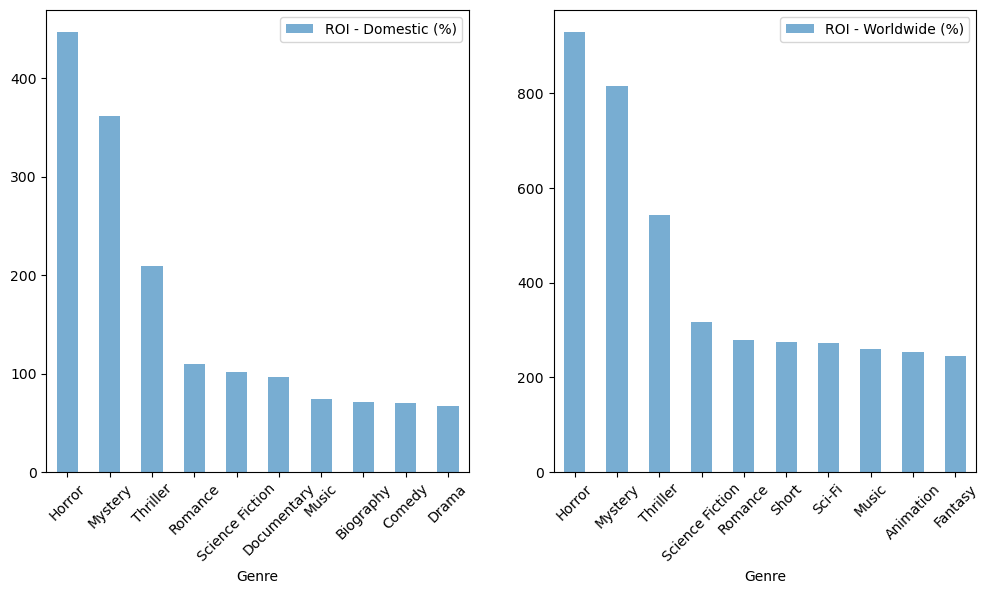

In [134]:
fig, ax=plt.subplots(1,2, figsize=(12,6))
df_genre_group[["ROI_domestic"]].mean().sort_values(by="ROI_domestic", ascending=False).head(10).plot(ax=ax[0],kind="bar", xlabel="Genre", rot=45, alpha=0.6);
ax[0].legend(["ROI - Domestic (%)"]);

df_genre_group[["ROI_worldwide"]].mean().sort_values(by="ROI_worldwide", ascending=False).head(10).plot(ax=ax[1],kind="bar", xlabel="Genre", rot=45, alpha=0.6);
ax[1].legend(["ROI - Worldwide (%)"]);
plt.savefig("./figures/roi_genre.png",bbox_inches = "tight")

**NOTE:** Exploding the dataframe by genre and calculating the average ROI per genre may over-inflate multi-genre movies; biasing the results towards genres that were bundled together. We could use alternative methods such as only selecting the first genre listed (not very accurate since genres are ordered alphabetically on IMDB) or weight each movie's ROI with the number of genres it's listed under (not very accurate either since we don't know how much each genre contributed or if the movie was primarily advertised under a certain genre). In the absence of more concrete information in this regard, we will suffice to the above analysis keeping in mind that Romance and Sci-Fi categories may also be considered as profitable if Horror, Mystery and Thriller genres are often bundled together in the dataset. 

### 4.2. Effect of Audience Average Rating

In order to study the effect of average rating, we first visualize how ROI changes with respect to average rating. We'd like to answer the following question: do higher-rated movies result in higher return on investments? 

Text(0, 0.5, '')

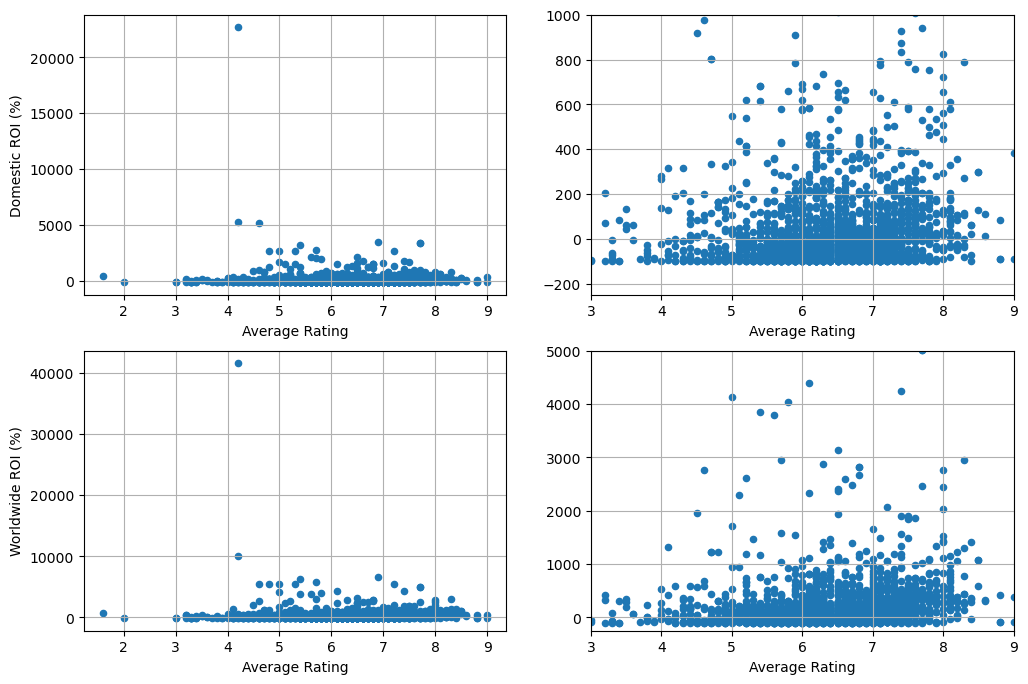

In [135]:
fig, ax=plt.subplots(2,2,figsize=(12,8))
df_final.plot(kind="scatter", ax=ax[0,0] ,x="average_rating", y = "ROI_domestic");
ax[0,0].grid('on')
ax[0,0].set_xlabel("Average Rating")
ax[0,0].set_ylabel("Domestic ROI (%)")

# zoom in
df_final.plot(kind="scatter", ax=ax[0,1] ,x="average_rating", y = "ROI_domestic", ylim=(-250,1000), xlim=(3,9));
ax[0,1].grid('on')
ax[0,1].set_xlabel("Average Rating")
ax[0,1].set_ylabel("")

df_final.plot(kind="scatter", ax=ax[1,0] ,x="average_rating", y = "ROI_worldwide");
ax[1,0].grid('on')
ax[1,0].set_xlabel("Average Rating")
ax[1,0].set_ylabel("Worldwide ROI (%)")

# zoom in
df_final.plot(kind="scatter", ax=ax[1,1] ,x="average_rating", y = "ROI_worldwide", ylim=(-250,5000), xlim=(3,9));
ax[1,1].grid('on')
ax[1,1].set_xlabel("Average Rating")
ax[1,1].set_ylabel("")

We cannot immediately see a pattern or relationship emerge from these figures. Let's look at the correlation coefficients. 

In [136]:
df_final[["ROI_domestic", "ROI_worldwide","average_rating", "domestic_gross","worldwide_gross", "production_budget"]].corr()

,ROI_domestic,ROI_worldwide,average_rating,domestic_gross,worldwide_gross,production_budget
ROI_domestic,1.000000,0.975556,-0.034693,0.081300,0.037218,-0.084697
ROI_worldwide,0.975556,1.000000,-0.007102,0.109164,0.095337,-0.049974
average_rating,-0.034693,-0.007102,1.000000,0.251479,0.248326,0.161185
domestic_gross,0.081300,0.109164,0.251479,1.000000,0.943213,0.721807
worldwide_gross,0.037218,0.095337,0.248326,0.943213,1.000000,0.790030
production_budget,-0.084697,-0.049974,0.161185,0.721807,0.790030,1.000000


There is interesting information in this table:
- The production budget, domestic gross and worldwide gross are highly correlated (as is expected) with positive correlation coefficients. This means movies with higher production budgets will yield higher domestic and worldwide revenues.
- Return on investment, however, has low correlation coefficients with the other variables across the board. In particular, average rating is very weakly correlated to ROI in a negative manner. The correlation coefficients are very low though so we should not make any strong conclusions from this observation.
- Average rating is mildly correlated to production budget, domestic and worldwide revenues in a positive manner. This makes sense. 

These are curious results. In what follows, we try to group the data based on average rating and try to see if we can explain the observations above in a better manner.

C:\Users\setar\AppData\Local\Temp\ipykernel_16420\730217291.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_averagerating_group = df_final.groupby("binned_rating")


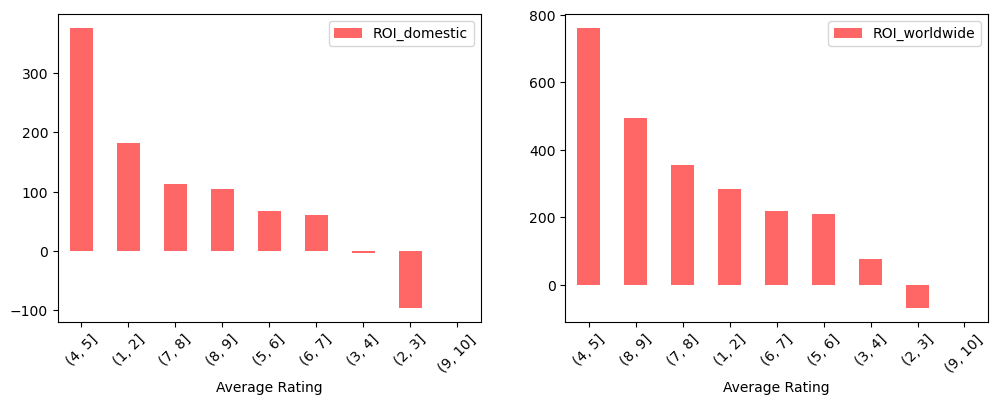

In [137]:
df_final["binned_rating"] = pd.cut(df_final["average_rating"], bins=range(1,11))
df_averagerating_group = df_final.groupby("binned_rating")

fig, ax = plt.subplots(1,2, figsize=(12,4))
df_averagerating_group[["ROI_domestic"]].mean().sort_values(by="ROI_domestic", ascending=False).head(10).plot(ax=ax[0],kind="bar", xlabel="Average Rating", rot=45, color="red", alpha=0.6);
df_averagerating_group[["ROI_worldwide"]].mean().sort_values(by="ROI_worldwide", ascending=False).head(10).plot(ax=ax[1],kind="bar", xlabel="Average Rating", rot=45, color="red", alpha=0.6);
plt.savefig("./figures/roi_average_rating.png",bbox_inches = "tight")

In [138]:
df_averagerating_group.size()

binned_rating
(1, 2]       2
(2, 3]       2
(3, 4]      30
(4, 5]     123
(5, 6]     430
(6, 7]     781
(7, 8]     443
(8, 9]      55
(9, 10]      0
dtype: int64

These plots seem to suggest that there's no clear-cut relationship between audience average ratings and domestic/worldwide ROIs. In particular, note that movies with average ratings between 4 and 5 seem to be the most profitable. This could have many reasons. For example, the dataset may lack enough number of data points in specific bins. For example, we only have 196 data points in the 4-5 bin which is only about 35% of the 5-6 bin and 22% of the 6-7 bin. Making these ratios more balanced by gathering more data might lead to more representative means and better insights. Another reason could be that the general public are most likely to watch average-rated movies. In other words, not everybody is necessarily interested in watching highly-acclaimed or highly-rated movies. 

### 4.3. Effect of Production Budget

Depending on the budget the stakeholders have for starting out, they may need to focus on different success criteria. Here, we will study the data by grouping it into low budget, medium budget and high budget categories to see what drives the ROI in each category. 

Let's look at some descriptive statistics to guide us in the binning process. 

In [139]:
df_final["production_budget"].describe()

count    1.866000e+03
mean     4.289674e+07
std      5.469083e+07
min      9.000000e+03
25%      7.000000e+06
50%      2.100000e+07
75%      5.100000e+07
max      4.106000e+08
Name: production_budget, dtype: float64

We will consider low-budget movies, movies with production budget below 7 million dollars; medium-budget movies as movies with production budget between 7 and 51 million dollars and high-budget movies as movies with production budget avoce 51 million dollars.

In [140]:
df_low_budget = df_final[df_final["production_budget"]<=7E6]
df_med_budget = df_final[(df_final["production_budget"]>7E6) & (df_final["production_budget"]<=51E6)]
df_high_budget = df_final[df_final["production_budget"]>51E6]

# df_high_budget[["ROI_domestic", "ROI_worldwide","average_rating", "domestic_gross","worldwide_gross", "production_budget"]].corr().iloc[2]

**Question:** Does higher budget mean higher rating? 

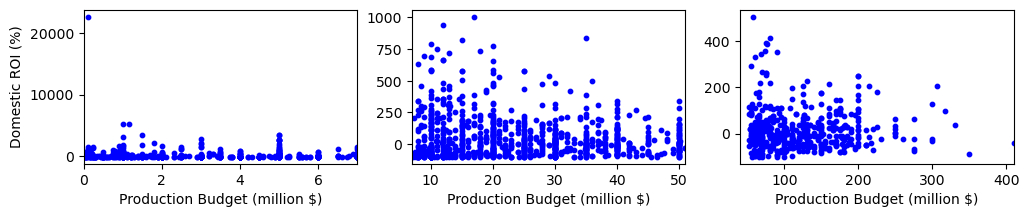

In [141]:
fig, ax=plt.subplots(1,3, figsize=(12,2))

# low-budget movies
ax[0].scatter(x = df_low_budget["production_budget"]/1E6, y = df_low_budget["ROI_domestic"],color="blue", s=10);
ax[0].set_xlim(0,7)
ax[0].set_xlabel("Production Budget (million $)");
ax[0].set_ylabel("Domestic ROI (%)");

# medium-budget movies
ax[1].scatter(x = df_med_budget["production_budget"]/1E6, y = df_med_budget["ROI_domestic"],color="blue", s=10);
ax[1].set_xlim(7,51)
ax[1].set_xlabel("Production Budget (million $)")

# high-budget movies
ax[2].scatter(x = df_high_budget["production_budget"]/1E6, y = df_high_budget["ROI_domestic"],color="blue", s=10);
ax[2].set_xlim(40,410)
# ax[2].set_ylim(-1000,2000)
ax[2].set_xlabel("Production Budget (million $)");

plt.savefig("./figures/roi_production_budget.png",bbox_inches = "tight")

In [142]:
print("correlation coefficients for low-budget movies:")
print(df_low_budget[["ROI_domestic", "ROI_worldwide","average_rating", "domestic_gross","worldwide_gross", "production_budget"]].corr())

print("correlation coefficients for medium-budget movies:")
print(df_med_budget[["ROI_domestic", "ROI_worldwide","average_rating", "domestic_gross","worldwide_gross", "production_budget"]].corr())

print("correlation coefficients for high-budget movies:")
print(df_high_budget[["ROI_domestic", "ROI_worldwide","average_rating", "domestic_gross","worldwide_gross", "production_budget"]].corr())

correlation coefficients for low-budget movies:
                   ROI_domestic  ROI_worldwide  average_rating  \
ROI_domestic           1.000000       0.985032       -0.088524   
ROI_worldwide          0.985032       1.000000       -0.074929   
average_rating        -0.088524      -0.074929        1.000000   
domestic_gross         0.444356       0.424809       -0.025391   
worldwide_gross        0.414306       0.435733       -0.003432   
production_budget     -0.060909      -0.040559       -0.000721   

                   domestic_gross  worldwide_gross  production_budget  
ROI_domestic             0.444356         0.414306          -0.060909  
ROI_worldwide            0.424809         0.435733          -0.040559  
average_rating          -0.025391        -0.003432          -0.000721  
domestic_gross           1.000000         0.954371           0.265955  
worldwide_gross          0.954371         1.000000           0.285915  
production_budget        0.265955         0.285915       

These are interesting results. Some observations:
- The correlation coefficients between ROI(s), domestic/worldwide gross as well as production budget and average rating are now stronger than the previous results.
- For low and medium budget movies, the correlation coefficient between ROI and production budget is negative, indicating that for these categories, keeping the budget low may improve profits.
- For high budget movies, however, the production budget has a positive correlation coefficient with ROI(s). This indicates that for this category, spending more money (to advertise, etc.) may yield higher profits.
- For low and medium budget movies, the correlation coefficient between ROI and production budget is negative, indicating that higher rating doesn't necessarily mean higher profits for these categories. However, for high-budget movies, average rating is positively correlated with ROI.

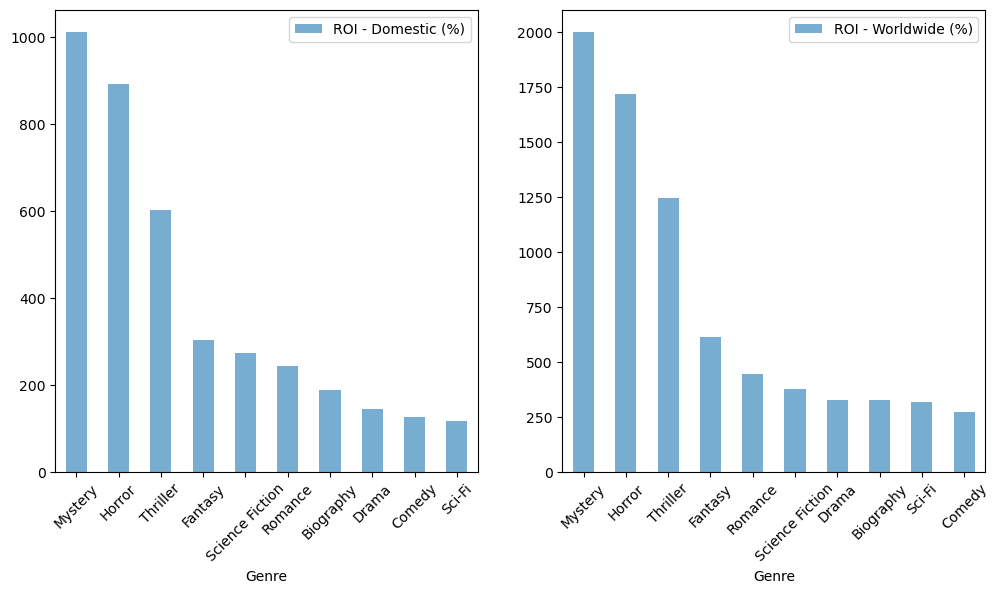

In [143]:
df_low_budget_genre_group = df_low_budget.explode("genres").groupby("genres")

fig, ax=plt.subplots(1,2, figsize=(12,6))
df_low_budget_genre_group[["ROI_domestic"]].mean().sort_values(by="ROI_domestic", ascending=False).head(10).plot(ax=ax[0],kind="bar", xlabel="Genre", rot=45, alpha=0.6);
ax[0].legend(["ROI - Domestic (%)"]);

df_low_budget_genre_group[["ROI_worldwide"]].mean().sort_values(by="ROI_worldwide", ascending=False).head(10).plot(ax=ax[1],kind="bar", xlabel="Genre", rot=45, alpha=0.6);
ax[1].legend(["ROI - Worldwide (%)"]);
# plt.savefig("./figures/ROI_genre.png",bbox_inches = "tight")

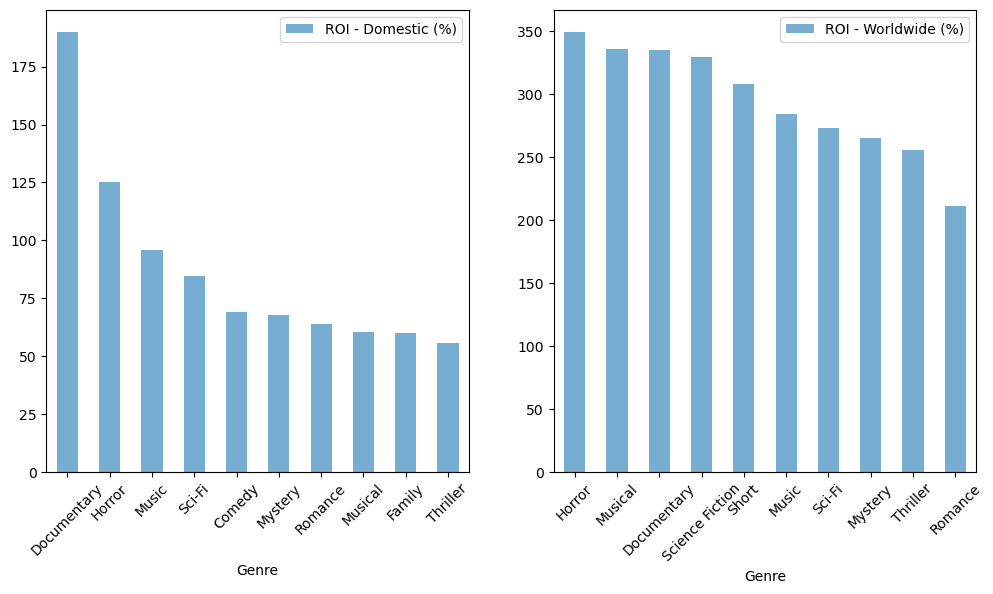

In [144]:
df_med_budget_genre_group = df_med_budget.explode("genres").groupby("genres")

fig, ax=plt.subplots(1,2, figsize=(12,6))
df_med_budget_genre_group[["ROI_domestic"]].mean().sort_values(by="ROI_domestic", ascending=False).head(10).plot(ax=ax[0],kind="bar", xlabel="Genre", rot=45, alpha=0.6);
ax[0].legend(["ROI - Domestic (%)"]);

df_med_budget_genre_group[["ROI_worldwide"]].mean().sort_values(by="ROI_worldwide", ascending=False).head(10).plot(ax=ax[1],kind="bar", xlabel="Genre", rot=45, alpha=0.6);
ax[1].legend(["ROI - Worldwide (%)"]);
# plt.savefig("./figures/ROI_genre.png",bbox_inches = "tight")

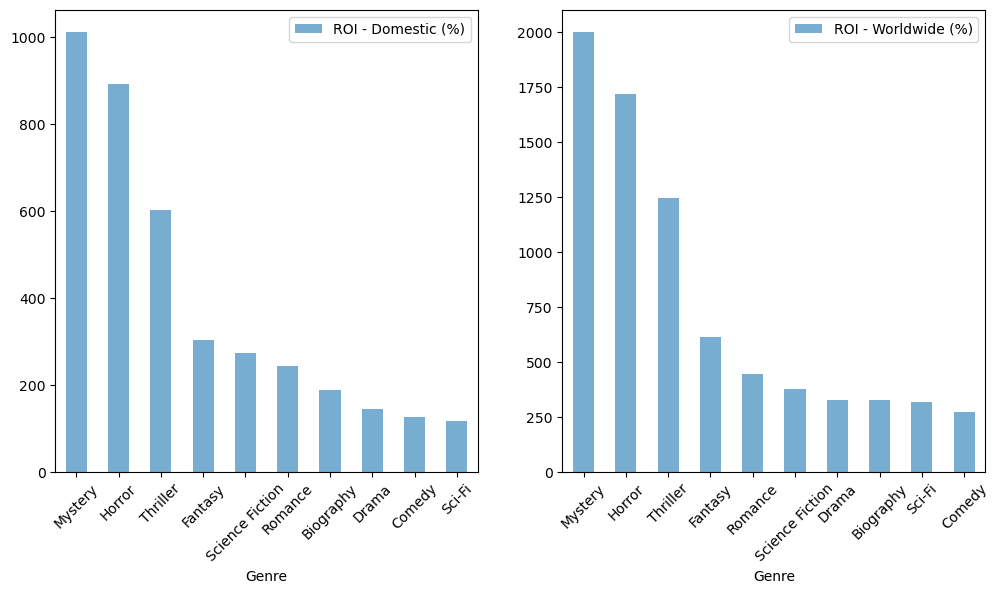

In [145]:
df_high_budget_genre_group = df_low_budget.explode("genres").groupby("genres")

fig, ax=plt.subplots(1,2, figsize=(12,6))
df_high_budget_genre_group[["ROI_domestic"]].mean().sort_values(by="ROI_domestic", ascending=False).head(10).plot(ax=ax[0],kind="bar", xlabel="Genre", rot=45, alpha=0.6);
ax[0].legend(["ROI - Domestic (%)"]);

df_high_budget_genre_group[["ROI_worldwide"]].mean().sort_values(by="ROI_worldwide", ascending=False).head(10).plot(ax=ax[1],kind="bar", xlabel="Genre", rot=45, alpha=0.6);
ax[1].legend(["ROI - Worldwide (%)"]);
# plt.savefig("./figures/ROI_genre.png",bbox_inches = "tight")

### 4.4. Release Month

C:\Users\setar\AppData\Local\Temp\ipykernel_16420\1601589042.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df_month_group = df_final.groupby("Month")


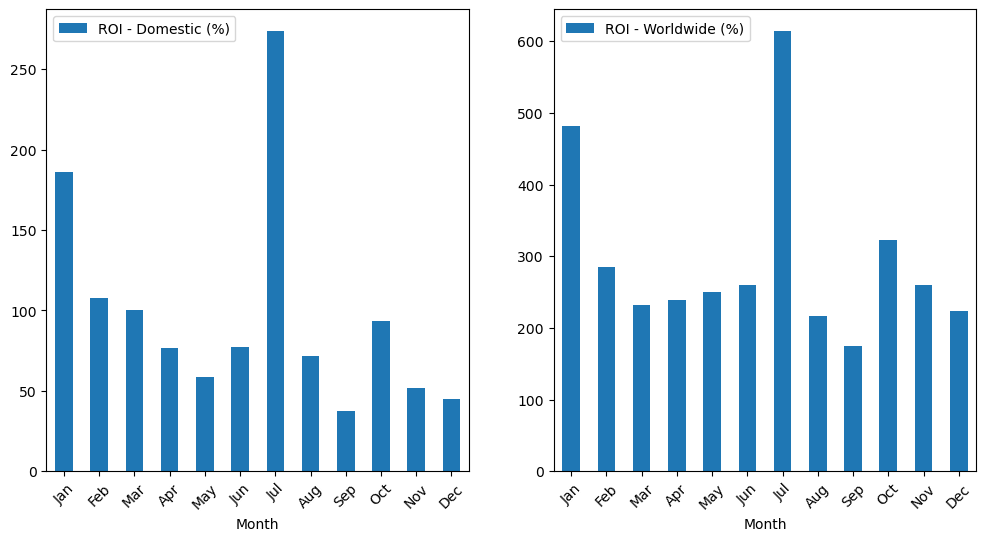

In [146]:
import calendar
df_final['Month'] = pd.DatetimeIndex(df_final['release_date']).month
df_final['Month'] = df_final['Month'].apply(lambda x: calendar.month_abbr[x])
month_order = month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
df_final['Month'] = pd.Categorical(df_final['Month'], categories=month_order, ordered=True)
df_month_group = df_final.groupby("Month")

fig, ax=plt.subplots(1,2, figsize=(12,6))
df_month_group[["ROI_domestic"]].mean().plot(ax=ax[0],kind="bar", xlabel="Month", rot=45);
ax[0].legend(["ROI - Domestic (%)"]);

df_month_group[["ROI_worldwide"]].mean().plot(ax=ax[1],kind="bar", xlabel="Month", rot=45);
ax[1].legend(["ROI - Worldwide (%)"]);
plt.savefig("./figures/roi_release_month.png",bbox_inches = "tight")

Movies released in July seem to have the highest ROI; this is followed by January. This may be due to the fact that audiences tend to watch movies in theaters more often during the summer. 

## 5. Results and Recommendations

1. Movies yielding the highest profit belong to the *horror*, *mystery* and *thriller* genres. For medium budget movies (budget between 7 to 51 million dollars), the documentary and musical genre also seem prominent in terms of revenue generation. 

<center><img src="./figures/roi_genre.png" 
    Width=1000">|"

2. It is recommended that the movie is released in July. If not in summer, it is recommended that the movie is released in the month of January since the results show high profits for movie releases in these months.

<center><img src="./figures/roi_release_month.png" 
    Width=1000">|

3. If the production budget is low or medium, it is recommended that it'd be kept to a minimum since the correlation coefficients for ROI and production budget are negative for these categories. However, for high-budget movies, it is recommended that use moderately higher numbers (to advertise the movie, etc.) since the correlation coefficients seem to suggest a positive effect between profitability and production budget.

4. Highly acclaimed/rated movies do not necessarily correlate with high profits. It is recommended that stakeholders stick with average-rated movies.

<center><img src="./figures/roi_average_rating.png" 
    Width=1000">|

## 6. Limitations and Next Steps

The following can be listed as the limitations of the following study:
- In the data cleaning stage, we did our best to keep the highest percentage of data possible while gathering information on movie genres, average ratings, production budget, and domestic/worldwide gross. As explained earlier, retreiving this information involved computationally demanding steps. It may be possible to optimize the search and match algorithms (for example using fuzzy matching techniques) to both improve performance and make our dataset even bigger using data from Box Office Mojo, for example. With the current techniques used in this work, that would have been time prohibitive.
- Our analysis of the production budget showed that the trends can indeed be different for low budget, medium budget and high budget movies. Since production budget is a factor stakeholders have control over, it would be beneficial to do a more in-depth analysis on the key factors contributing to the success of movies in each category. This will help stakeholders focus on those key driving factors depending on the budget at hand.
- The current work does not present a model that can describe return on investment as a function of factors such as genre, average rating, etc. It would be beneficial to build statistically significant linear regression models that could better explain the evolution of ROI with these factors. This would require treating the categorical variables (e.g. genre) and is beyond the scope of the current work.    